In [1]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.sandbox.stats.runs import runstest_1samp

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

# 1) Read GeoJSON file
data = gpd.read_file("similarity_matrix_result.geojson")

In [2]:
data.shape

(15911, 16)

### One hot encoding

In [3]:
data_transformed = pd.get_dummies(data, columns=['operator_number', 'flowline_id', 'location_id', 'status', 'location_type', 'fluid', 'material', 'root_cause'], drop_first=True)

# List of original columns that are not one-hot encoded
original_columns = data.columns.tolist()

# List of new columns that are the result of get_dummies
new_dummy_columns = [col for col in data_transformed.columns if col not in original_columns]

# Convert only the dummy columns to int
data_transformed[new_dummy_columns] = data_transformed[new_dummy_columns].astype(int)

In [4]:
data_transformed.shape

(15911, 5306)

In [5]:
data_transformed = data_transformed.drop(columns=['geometry'])

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, shapiro, anderson, chi2_contingency, spearmanr
from statsmodels.stats.diagnostic import acorr_ljungbox

### Autocorrelation Test (Ljung-Box)

Interpretation: If p-value < 0.05, reject independence

In [7]:
# Choose a random column (or the first one) for testing
column_to_test = data.iloc[:, 0]  

# Ljung-Box test (null hypothesis: data is independent)
lb_test = acorr_ljungbox(column_to_test.dropna(), lags=[10], return_df=True)
print(lb_test)

          lb_stat  lb_pvalue
10  120223.792183        0.0


###  Spearman Rank Correlation (Across Rows/Columns)
If p-value < 0.05, columns are correlated → data is not independent.

In [8]:
# Check correlation between two randomly selected columns
col1, col2 = np.random.choice(data.columns, 2, replace=False)
rho, p_val = spearmanr(data[col1].dropna(), data[col2].dropna())

print(f"Spearman Correlation: {rho}, p-value: {p_val}")

Spearman Correlation: -0.029187861562380877, p-value: 0.00023121411784757787


### Kolmogorov-Smirnov (KS) Test
If p-value < 0.05, reject identical distribution.

In [9]:
# Split dataset into two equal parts (first half vs. second half)
split_index = len(data) // 2
sample1 = data.iloc[:split_index, 0].dropna()
sample2 = data.iloc[split_index:, 0].dropna()

ks_stat, ks_pval = ks_2samp(sample1, sample2)
print(f"KS Test Statistic: {ks_stat}, p-value: {ks_pval}")

KS Test Statistic: 0.05812008472747187, p-value: 4.136251430211696e-12


### Shapiro-Wilk Normality Test
If p-value < 0.05, data is not normally distributed.


In [22]:
# Test normality of two random columns
col_test = np.random.choice(data.columns, 1)[0]
sample = data[col_test].dropna().sample(500)  # Take a subset (Shapiro-Wilk max is ~5000)

shapiro_stat, shapiro_pval = shapiro(sample)
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, p-value: {shapiro_pval}")

Shapiro-Wilk Test Statistic: 0.6309353179304134, p-value: 2.312651988572193e-31


### Chi-Square test
If p-value < 0.05, data is not identically distributed.


In [24]:
# Convert data to categories (bins) for chi-square test
binned_data = pd.cut(data.iloc[:, 0], bins=10).value_counts()
observed = np.array(binned_data)

# Create an expected uniform distribution
expected = np.ones_like(observed) * observed.mean()

# Perform chi-square test
chi2_stat, chi2_pval, _, _ = chi2_contingency([observed, expected])
print(f"Chi-Square Statistic: {chi2_stat}, p-value: {chi2_pval}")

Chi-Square Statistic: 16955.59141571558, p-value: 0.0


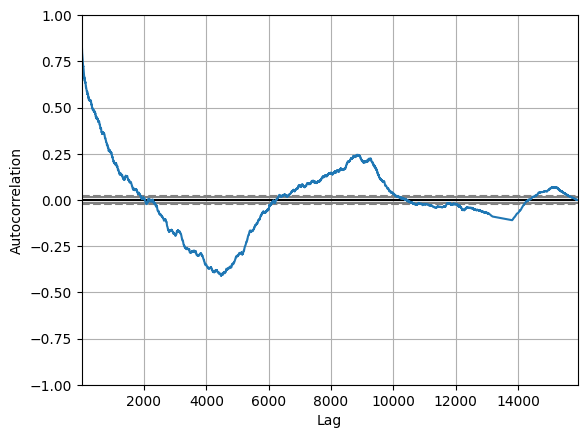

In [25]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data.iloc[:, 0].dropna())
plt.show()

Autocorrelation Measures Spatial Dependence
- Instead of showing how data correlates over time, this plot suggests how values at different locations influence each other.
- High autocorrelation at low lags means nearby locations have similar values.
- The drop and rise in correlation at larger lags could indicate spatial clustering or periodic spatial patterns in your dataset.

Negative Autocorrelation at Mid-Lags (~4000-6000)
- This suggests that at a certain distance, values tend to be dissimilar (e.g., areas of high values tend to be surrounded by low values at this distance).
- This might indicate a spatial oscillation or alternating high-low values in your dataset.

Resurgence of Positive Autocorrelation (~8000-10000)
- This suggests that at a larger distance, the data becomes correlated again.
- Possible explanation: Regional clustering of similar values (e.g., certain environmental or demographic zones).

Crossing the Confidence Bands
- Since the autocorrelation values are outside the gray bands at multiple points, the observed spatial correlations are statistically significant and not just random noise.
- This strongly suggests that your data has structured spatial dependence.